# 02807 Computational Tools for Data Science
##### November 28, 2023
__*Authors*__
- Vidisha Sinha - s204081
- David van Scheppingen - s222902
- Ari Goldhar Menachem - s163956
- Magnus Nikolaj Nyholm Jensen - s184677
***


In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import cm, ticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from collections import Counter
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import warnings
from wordcloud import WordCloud
from datetime import datetime
warnings.filterwarnings("ignore")

## Web scraping

In [202]:
def scrape_guardian_article(df_row):
    # Get soup
    soup = df_row['soup']

    # Attempt to get summary
    summary_tag = soup.find('div', {'data-gu-name': 'standfirst'})
    summary = summary_tag.get_text(strip=True) if summary_tag else None

    # Attempt to get author
    author_tag = soup.find('a', rel='author')
    author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags[1:])

    # Attempt to get date
    date_tag = soup.find('span', class_='dcr-u0h1qy')
    date_string = date_tag.get_text(strip=True) if date_tag else 'Unknown'

    """
    # Parse the date if it's not 'Unknown'
    if date_string != 'Unknown':
        try:
            date_format = "%B %d, %Y %I:%M%p"
            date = datetime.strptime(date_string, date_format)
        except ValueError:
            date = 'Unknown'
    else:
        date = 'Unknown'

    """

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

## Scraper function to scrape articles from The Washington Post
def scrape_washington_post_article(df_row):
    # Get soup
    soup = df_row['soup']

    # Attempt to get summary
    summary = None
    summary_candidates = ['PJLV PJLV-iPJLV-css grid-center w-100']
    for candidate in summary_candidates:
        summary_tag = soup.find(class_=candidate)
        if summary_tag:
            summary = summary_tag.get_text(strip=True)
            break

    # Attempt to get author
    author = None
    author_candidates = ['wpds-c-cNdzuP wpds-c-cNdzuP-ejzZdU-isLink-true', 'a[data-qa="author-name"]']
    authors = []
    for candidate in author_candidates:
        author_tags = soup.find_all(class_=candidate) or soup.find_all('a', {'data-qa': 'author-name'})
        for tag in author_tags:
            authors.append(tag.get_text(strip=True))
    author = ' and '.join(authors)

    # Get content
    content_list = soup.find_all(class_='article-body grid-center grid-body') or soup.find_all('p')
    content = ' '.join(content.get_text(strip=True) for content in content_list)

    # Get date
    date_string = None
    date_candidates = ['wpds-c-iKQyrV', 'wpds-c-iKQyrV wpds-c-iKQyrV-ihqANPJ-css overrideStyles']
    for candidate in date_candidates:
        date_tag = soup.find(class_=candidate)
        if date_tag:
            date_string = date_tag.get_text(strip=True)
            #date_string = date_string.replace('.m.', 'm').replace('EST', '').strip()
            break

    # Parse the date
    #date_format = "%B %d, %Y at %I:%M %p"
    #date = datetime.strptime(date_string, date_format) if date_string else None

    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

## Scraper function to scrape articles from The New York Post
def scrape_ny_post_article(df_row):
    # Get soup
    soup = df_row['soup']

    # No summaries exist
    summary = None

    # Get author
    author_tag = soup.find('span', class_='meta__link')
    author = author_tag.get_text(strip=True)[16:] if author_tag else 'Unknown'

    # Get content
    content_list = soup.find_all('p')[1:-1]
    content = ' '.join(content.get_text(strip=True) for content in content_list)

    # Get date
    date_tag = soup.find('div', class_='date--updated__item')
    date_string = date_tag.find_all('span')[1].get_text(strip=True) if date_tag else 'Unknown'
    #date_string = date_string.replace('.m.', 'M').replace('ET', '').strip()
    #date_format = "%b. %d, %Y, %I:%M %p"
    #try:
        #date = datetime.strptime(date_string, date_format)
    #except ValueError:
        #date = 'Unknown'

    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

## Scraper function to scrape articles from The Atlantic
def scrape_atlantic_article(df_row):
    # Get soup
    soup = df_row['soup']

    # Attempt to get summary
    summary_tag = soup.find(class_='ArticleHero_dek__EqdkK')
    summary = summary_tag.get_text(strip=True) if summary_tag else None

    # Attempt to get author
    author_tag = soup.find(class_='ArticleBylines_link__kNP4C')
    author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p', class_='ArticleParagraph_root__4mszW')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags)

    # Attempt to get date
    date_tag = soup.find('time', class_='ArticleTimestamp_root__b3bL6')
    date = date_tag['datetime'] if date_tag else 'Unknown'

    # Parse the date if it's not 'Unknown'
    #if date != 'Unknown':
        #try:
            #date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ').isoformat()
        #except ValueError:
            #date = 'Unknown'

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    df_row['date'] = date

    return df_row

## Scraper function to scrape articles from CNN
def scrape_cnn_article(df_row):
    # Get soup
    soup = df_row['soup']

    # No summaries for CNN articles
    summary = None

    # Check if it's a live news article and get the author, content, and date accordingly
    if '/live-news/' in df_row['url']:
        author_tag = soup.find('p', {'data-type': 'byline-area'})
        author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

        content_tags = soup.find_all('p', class_='sc-gZMcBi render-stellar-contentstyles__Paragraph-sc-9v7nwy-2 dCwndB')
        content = ' '.join(tag.get_text(strip=True) for tag in content_tags)

        date_tag = soup.find('div', class_='hJIoKL')
        date = date_tag.get_text(strip=True) if date_tag else 'Unknown'
        date_string = ' '.join(date.split(' ')[-3:])+' '+str(date.split(' ')[2][1:3])+':'+(date.split(' ')[2][3:5]) if date!='Unknown' else 'Unknown'
    else:
        author_tag = soup.find(class_='byline__link')
        author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

        content_tags = soup.find_all('p', class_='paragraph inline-placeholder')
        content = ' '.join(tag.get_text(strip=True) for tag in content_tags)

        date_tag = soup.find(class_='timestamp')
        #date_string = ' '.join(date_tag.get_text(strip=True).split(' ')[-7:][-3:]+date_tag.get_text(strip=True).split(' ')[-7:][0:2]) if date_tag else 'Unknown'
        date_string = date_tag.get_text(strip=True).split('\n')[-1] if date_tag else 'Unknown'

    # Parse the date if it's not 'Unknown'
    """
    if date_string != 'Unknown':
        try:
            if '/live-news/' in df_row['url']:
                date_format = "%B %d, %Y %H:%M"
            else:
                date_format = '%B %d, %Y %I:%M %p'
            date = datetime.strptime(date_string, date_format).isoformat()
        except ValueError:
            date = 'Unknown'
    """

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

## Scraper function to scrape articles from Business Insider
def scrape_business_insider_article(df_row):
    # Get soup
    soup = df_row['soup']
    
    # No summary for BI
    summary = None

    # Attempt to get author
    author_tag = soup.find(class_='byline-author headline-bold')
    author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags[1:])

    # Attempt to get date
    date_tag = soup.find('div', class_='byline-timestamp')
    date = date_tag['data-timestamp'] if date_tag else 'Unknown'

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    df_row['date'] = date

    return df_row

## Scraper function to scrape articles from Fox News
def scrape_fox_news_article(df_row):
    # Get soup
    soup = df_row['soup']

    # Attempt to get summary
    summary_tag = soup.find('h2', class_='sub-headline speakable')
    summary = summary_tag.get_text(strip=True) if summary_tag else None

    # Attempt to get author
    author_tag = soup.find(class_='author-byline')
    author = author_tag.get_text().split('\n')[-1].replace('Fox News','').strip() if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags[1:])

    # Attempt to get date
    date_tag = soup.find('time')
    #date_string = date_tag.get_text(strip=True)[:-4] if date_tag else 'Unknown'
    date_string = date_tag.get_text(strip=True) if date_tag else 'Unknown'

    """
    # Parse the date if it's not 'Unknown'
    if date_string != 'Unknown':
        try:
            date_format = "%B %d, %Y %I:%M%p"
            date = datetime.strptime(date_string, date_format)
        except ValueError:
            date = 'Unknown'
    else:
        date = 'Unknown'

    """

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

In [203]:
class Top_News:
    # Class initializer with publication names and setup for scraping functions and class data
    def __init__(self, publication_names):
        self.publication_names = publication_names if publication_names != 'all' else ['NY Post', 'Atlantic', 'CNN', 'Business Insider', 'Washington Post', 'Fox News', 'Guardian']
        self.results_df = pd.DataFrame()
        # Dictionary containing scraping function for each publication
        self.scrapers = {
            'NY Post': scrape_ny_post_article,
            'Atlantic': scrape_atlantic_article,
            'CNN': scrape_cnn_article,
            'Business Insider': scrape_business_insider_article,
            'Washington Post': scrape_washington_post_article,
            'Fox News': scrape_fox_news_article,
            'Guardian': scrape_guardian_article
        }
        # Dictionary containing class data for each publication to locate articles on their homepage
        self.class_data = {
            'NY Post': ['https://nypost.com/', 'story__headline headline headline--xl', 'story__headline headline headline--sm', 'story__headline headline headline--combo-lg-xl headline--with-inline-webwood'],
            'Atlantic': ['https://www.theatlantic.com/world/', 'HomepageBottom_channelArticle__2wxRe', 'SmallPromoItem_root__nkm_2', 'Lede_title__7Wg1g', 'Offlede_title__kiinC', 'QuadBelt_title__mB6Zf', 'DoubleWide_title__diUPi', 'DoubleStack_title___FhPb', 'Latest_article__DW75m', 'Popular_listItem__CtMMj'],
            'CNN': ['https://edition.cnn.com/', 'container__link', 'container__title container_lead-package__title container__title--emphatic hover container__title--emphatic-size-l1'],
            'Business Insider': ['https://www.businessinsider.com/', 'tout', 'quick-link', 'most-popular-item', '.featured-tout-collection-wrapper .tout-title a', '.two-column-wrapper .tout-title-link'],
            'Washington Post': ['https://www.washingtonpost.com/', 'wpds-c-iiQaMf wpds-c-iiQaMf-igUpeQR-css', 'wpds-c-iiQaMf wpds-c-iiQaMf-ikZTsyd-css', 'wpds-c-iiQaMf wpds-c-iiQaMf-ibYgSwf-css'],
            'Fox News': ['https://www.foxnews.com/', 'article'],
            'Guardian': ['https://www.theguardian.com/', 'dcr-12ilguo', 'dcr-yw3hn9']
        }
    
    def _get_soup(self, url,rate_limit_seconds=1):
        try:
            # implement rate limiting for ethical reasons
            time.sleep(rate_limit_seconds)
            # try to get response from server and parse it into a BeautifulSoup object
            response = requests.get(url)
            response.raise_for_status()  
            return BeautifulSoup(response.text, 'html.parser')
        except requests.exceptions.RequestException as e:
            # handle exceptions
            print(f"Request failed for {url}: {e}")
            return None

    def scrape_publications(self):
        # use class data to find and parse articles from homepages
        selected_class_data = {name: self.class_data[name] for name in self.publication_names if name in self.class_data}
        articles_data = []
           
        for class_name in selected_class_data:
            # find articles and collect data
            base_url = selected_class_data[class_name][0]
            soup = self._get_soup(base_url)
            
            # find article blocks
            article_blocks = []
            for c_ in selected_class_data[class_name][1:]:
                temp = soup.find_all(class_=c_) if (class_name != 'Fox News') else soup.find_all('article')
                temp = temp if temp else soup.select(c_)
                article_blocks.extend(temp)
            
            # extract data from each block
            for block in article_blocks:
                url = block.find('a')['href'] if block.find('a') else (block['href'] if 'href' in block.attrs else None)
                if url:
                    article_data = {
                        'name': class_name,
                        'title': block.get_text(strip=True),
                        'url': base_url[:-1]+url if url.startswith('/') else url,
                        'soup': self._get_soup(url) # get content of article
                    }
                    articles_data.append(article_data)

        self.results_df = pd.DataFrame(articles_data)
        # drop duplicates
        self.results_df.drop_duplicates(subset=['url'], inplace=True)
        self.results_df.reset_index(drop=True, inplace=True)

        return self.results_df

    def article_distribution(self):
        if not self.results_df.empty:
            # plot distribution of articles from different publishers
            self.results_df.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
            plt.gca().spines[['top', 'right',]].set_visible(False)
            plt.show()
        else:
            print('Scrape publications first')

    def scrape_articles(self, max_articles_per_publication=None):
        if self.results_df.empty:
            print("Scraping publications for article URLs...")
            self.scrape_publications()

        all_article_data = []
        articles_count = {}

        for index, row in self.results_df.iterrows():
            publication_name = row['name']
            if publication_name in self.scrapers:
                articles_count.setdefault(publication_name, 0)
                # do not scrape more than the desired number of articles per publisher
                if max_articles_per_publication is None or articles_count[publication_name] < max_articles_per_publication:
                    try:
                        article_data = self.scrapers[publication_name](row)
                        all_article_data.append(article_data)
                        articles_count[publication_name] += 1
                    except Exception as e:
                        print(f"An error occurred while scraping {row['url']}: {e}")

        self.results_df = pd.DataFrame(all_article_data)
        self.results_df.reset_index(drop=True, inplace=True)

In [204]:
def scraper(filename='scraping_data.csv', publication_list='all', max_limit_num_articles=None):
    news_scraper = Top_News(publication_list)
    news_scraper.scrape_publications()
    #news_scraper.article_distribution()
    news_scraper.scrape_articles(max_articles_per_publication=max_limit_num_articles)
    filename = os.path.join('./data/', filename)
    news_scraper.results_df.to_csv(filename, index=False)

### Scrape the web:

In [205]:
# select_agencies = ['NY Post','Atlantic','CNN','Business Insider','Washington Post','Fox News','Guardian']
# number_of_articles = 10
# scraper(filename="new_scraping_data.csv", publication_list=select_agencies, max_limit_num_articles=int(number_of_articles))   

### TF-IDF class

In [206]:
class TFIDF:
    
    def __init__(self, df):
        self.df = df
        try:
            nltk.download('stopwords') # Download necessary NLTK resources to remove stop words
        except nltk.exceptions.AlreadyDownloaded:
            # Handle the case where the resource is already downloaded
            pass
    def preprocess_articles(self, text):
        text = text.lower() # Convert data to lover case to remove multiple occurences of the same word
        text = re.sub(r'[^a-z\s]', '', text) # Remove special characters, digits and white space using regex expression
        stop_words = set(stopwords.words('english')) # Import stop words from nltk library
        words = [word for word in text.split() if word not in stop_words] # Extract all words that are not stop words
        stemmer = PorterStemmer() # Apply stemming using nltk PorterStemmer
        stemmed_words = [stemmer.stem(word) for word in words]
        return ' '.join(stemmed_words)
    
    def preprocess_text_lowercase(self, text):
        # Converts to lowercase, removes symbols and stopword, but does not stem
        # Used for wordclouds
        text = text.lower()
        # Remove special characters, digits and white space using regex expression
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in text.split() if word not in stop_words]
        return ' '.join(tokens)

    # Create vocabulary of words from news articles
    def vocabulary(self, docs):
        vocab = set()
        for doc in docs:
            for word in doc:
                vocab.add(word)
        return sorted(vocab)

    # Calculate Term frequency
    def term_frequency(self, docs, vocab):
        tf = pd.DataFrame(0, index=range(len(docs)), columns=vocab)
        for i, document in enumerate(docs):
            num_words_doc = len(document)
            for word in document:
                tf.at[i, word] += document.count(word)/num_words_doc
        return tf

    # Inverse Document Frequency
    def inverse_document_frequency(self, docs, vocab):
        # We want to reduce the weight of terms that appear frequently in our collection of articles.
        idf = pd.Series(0, index=vocab) # Create series and set all elements to 0
        for word in vocab:
            counter = 0
            for doc in docs:
                if word in doc:
                    counter +=1
            idf[word] = np.log((len(docs))/(counter+1)) #TFIDF as stated in the slides of week 1
        return idf
    
    # TF-IDF
    def tf_idf(self, tf, idf, docs, vocab):
        tfidf = pd.DataFrame(index=range(len(docs)), columns=vocab)  # Create an empty DataFrame
        for i in range(len(docs)):
            tfidf.iloc[i] = tf.iloc[i]*idf  # Multiply TF values by IDF for each term
        tfidf = normalize(tfidf, norm='l2', axis=1)  # L2 normalization to scale vectors
        tfidf = pd.DataFrame(tfidf, columns=vocab)
        return tfidf

    def fit(self):
        # Apply preprocesing to news articles
        self.df['preprocessed_content'] = self.df['content'].apply(self.preprocess_articles)
        self.df['content_lowercase'] = self.df['content'].apply(self.preprocess_text_lowercase)
        content_lowercase_dataframe = self.df['content_lowercase'] # pd.DataFrame()
        content_lowercase_dataframe = pd.DataFrame(content_lowercase_dataframe)
        # Extract words from each news articles
        docs = self.df['preprocessed_content'].str.split()
        # Create a vocabulary corresponding to all the words in every news article
        vocab = self.vocabulary(docs)
        # Calculate the TF
        tf = self.term_frequency(docs, vocab)
        # Calculate the IDF
        idf = self.inverse_document_frequency(docs, vocab)
        # Multiply TF with IDF and calculate TF-IDF
        tfidf = self.tf_idf(tf, idf, docs, vocab)
        return tfidf, content_lowercase_dataframe

### K-means clustering class

In [207]:
class KMeansAlgorithm:

    def __init__(self, X, k, max_iterations=100):
      self.X = X.values
      self.k = k
      self.max_iterations = max_iterations
      self.centroids = None
      self.num_articles = X.shape[0]

    def init_random_centroids(self):
      # Initializing KMeans by choosing random centroids 
      idx = np.random.choice(self.num_articles, size=self.k, replace=False) # Extract random indices from dataframe
      centroids = self.X[idx] # Pick random rows from the dataframe
      return centroids

    def calculate_euclidean_distances(self):
      # Calculate distances from vector/row to centroid
      num_centroids = self.centroids.shape[0]
      distances = np.zeros((num_centroids, self.num_articles))

      for centroid_idx in range(num_centroids):
          for article_idx in range(self.num_articles):
              distances[centroid_idx, article_idx] = np.sqrt(np.sum((self.centroids[centroid_idx, :] - self.X[article_idx, :]) ** 2))
      return distances

    def update_centroids(self, labels):
        # Calculate the mean of each cluster as new centroid
        new_centroids = []
        for k in range(self.k):
            mean = self.X[labels == k].mean(axis=0)
            new_centroids.append(mean)
        new_centroids = np.array(new_centroids)
        return new_centroids

    def plot_clusters(self, labels, centroids, iteration):
        # We will use PCA to plots clusters as the TFIDF matrix has many dimensions
        unique_labels = np.unique(labels)
        pca = PCA(n_components=3)
        data_3d = pca.fit_transform(self.X)
        centroids_3d = pca.transform(centroids)
        # 3D plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        color_map = cm.get_cmap('turbo', len(unique_labels))
        # Plot data
        for label in unique_labels:
            indices = labels == label # like [1, 2, 1, 3, 1]
            ax.scatter(data_3d[indices, 0], data_3d[indices, 1], data_3d[indices, 2], label=f'Cluster {label}', c=[color_map(label)])
        # Plot centroids
        ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c='red', marker='x', s=80, label='Centroids')
        # ax.set_title(f'PCA 3D - iteration {iteration}')
        ax.set_xlabel('Principal component 1')
        ax.set_ylabel('Principal component 2')
        ax.set_zlabel('Principal component 3')
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
        clear_output(wait=True)
        plt.show()
        fig.savefig('figures/PCA-plot.png', bbox_inches='tight', pad_inches=0.25)    

    def fit(self):
      print("Clustering: KMeans fit()", datetime.now().strftime("%H:%M:%S"))
      
      # Run the Kmeans algorithm using helper functions
      self.centroids = self.init_random_centroids() # Init centroids

      for i in range(self.max_iterations):
        distances = self.calculate_euclidean_distances() # calculate eucledian distances
        labels = np.argmin(distances, axis=0) # Assign to the cluster with the centroid that has the minimum distance to that point
        new_centroids = self.update_centroids(labels) # Calculated centroids based on mean of the points in that cluster

        if np.all(new_centroids == self.centroids): # If no new centroids break loop
          print("Clustering: Kmeans has converged!", datetime.now().strftime("%H:%M:%S"))
          break

        self.centroids = new_centroids
        self.plot_clusters(labels, self.centroids, i) # Plot PCA 3D plot

      return labels

In [208]:
def extract_documents(df):
    """
    Main TF-IDF Function
    Total time for 500 articles: 20 minutes

    Args:
        df (dataframe): dataframe with preprocessed content
        
    Returns:
        tf idf matrix
    """
    tfidf = TFIDF(df)
    tfidf_matrix, content_lowercase_dataframe = tfidf.fit()

    return tfidf_matrix, content_lowercase_dataframe

def Cluster_Articles(k, data):
    """Main cluster articles function

    Args:
        k (int): nr clusters
        data (dataframe): PD dataframe with contents, etc.

    Returns:
        dataframe: df with ['clusters'] appended
    """
    tfidf_matrix, dummy = extract_documents(data)
    Kmeans = KMeansAlgorithm(tfidf_matrix, k) # Optimal number of clusters is determined from the results of the elbow method
    labels = Kmeans.fit()
    data['cluster'] = labels
    return data

def elbow_method(data):
    # We will use elbow method to determine optimal number of clusters
    num_clusters = range(1, 31)
    wcss = []

    for k in num_clusters:
        # We will use Sklearn's Kmeans algorithm, but use random intialization as used in our implementation
        kmeans = KMeans(n_clusters=k, init='random', random_state=123)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method
    fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True, sharey=True)
    lines = plt.plot(num_clusters, wcss)
    plt.setp(lines, color='tab:grey', linewidth=3.0, linestyle='-', marker='s', markerfacecolor='C0', markeredgecolor='k',  markersize=7.5)
    # plt.annotate('Elbow', xy=(10, 86.25), xytext=(12, 90), arrowprops=dict(facecolor='black', shrink=0.05))
    # plt.title('Elbow Method - KMeans with random initialization')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.show()
    fig.savefig('figures/elbow-plot.png', bbox_inches='tight', pad_inches=0.25)    

In [216]:
def generate_wordclouds(content_lowercase_dataframe, cluster_labels):
    # Create dataframe with cluster numbers as columns and individual articles as rows
    # The (lowercase) content of each article will be assigned to the corresponding row (article) and column (cluster) of the dataframe
    # Remaining cells will be null
    clusters_dataframe = pd.DataFrame()

    list_to_append = [] # Row of null values that can be appended to dataframe

    for i in range(len(np.unique(cluster_labels))):
        clusters_dataframe[str(i)] = ''
        list_to_append.append(np.nan)

    # Looping through the cluster labels of all articles
    for i in range(len(cluster_labels)):
        # Initialize row with null values
        clusters_dataframe.loc[len(clusters_dataframe.index)] = list_to_append
        # Add article to the cluster it belongs to in the dataframe
        clusters_dataframe.loc[i,str(cluster_labels[i])] = content_lowercase_dataframe.loc[i,'content_lowercase']

    # display(clusters_dataframe.shape)

    # This DataFrame has only one row, and the same number of columns as there are clusters.
    # Every column contains ALL the text of a given cluster.
    text_cluster_df = pd.DataFrame()

    list_to_append = [] # Row of null values that can be appended to dataframe

    for i in range(clusters_dataframe.shape[1]):
        text_cluster_df[str(i)] = ''
        list_to_append.append(np.nan)

    # Initialize first row
    text_cluster_df.loc[len(text_cluster_df.index)] = list_to_append

    # text_cluster_df.head()

    text = []
    # Outer loop: The number of clusters
    for i in range(clusters_dataframe.shape[1]):
        # Inner loop: Number of articles
        for j in range(clusters_dataframe.shape[0]):
            if (pd.notnull(clusters_dataframe.loc[j,str(i)])):
                # If the field is not null, then append the text to be added for the given cluster
                text.append(clusters_dataframe.loc[j,str(i)])
        text_cluster_df.loc[0, str(i)] =  ' '.join(text)
        text = []

    # WORDCLOUD
    wordclouds = []
    for i in range(text_cluster_df.shape[1]):
        text = text_cluster_df.loc[0,str(i)]
        # Create and generate a word cloud image:
        wordcloud = WordCloud(max_font_size=50, max_words=15, background_color="white").generate(text)
        wordclouds.append(wordcloud)

    plt.figure(figsize=(17, 17))
    for n, cloud in enumerate(wordclouds):
        # add a new subplot iteratively
        ax = plt.subplot(7, 3, n + 1)
        ax.imshow(cloud, interpolation="bilinear")
        ax.set_xlabel(str(n+1), fontsize=18)
        plt.xticks([])
        plt.yticks([])

    plt.savefig('figures/wordclouds-nolib.png', bbox_inches='tight', pad_inches=0.25)    

### Load datasets to analyze
- One or more datasets can be loaded.

In [2]:
# dataset_paths = [file for file in os.listdir("./data/") if file.endswith(('csv'))] # Select all available data files
# dataset_paths = ["scraping_data_filtered.csv"]
dataset_paths = ["Monday_new_scraping_data_filtered.csv"]
# dataset_paths = ["articles1.csv"]

# Load data
data_frames = []
data = []
DATA_LIMIT = 500 # how many items to load
for data_path in dataset_paths:
    data_frames.append(pd.read_csv(os.path.join('./data/', data_path)).head(DATA_LIMIT))
data = pd.concat(data_frames)
data = data.drop(['Unnamed: 0', 'date', 'url'], axis=1, errors='ignore')

if len(data) > 0:
        # display dataframe header
        print("First 20 entries in data (size " + str(len(data)) + "):")
        display(data.head(20))

First 20 entries in data (size 443):


,Unnamed: 0.1,name,title,author,content,day,month,year
0,0,NY Post,Two in custody after allegedly attacking Jewis...,Amanda Woods,Two women have been slapped with hate crime ch...,27.0,11.0,2023.0
1,1,NY Post,Hamas frees 11 more hostages as US hopes two A...,Ronny Reyes,Hamas freed11 more Israeli hostages— nine chil...,27.0,11.0,2023.0
2,2,NY Post,NBA star at risk of losing $40 million over al...,Jenna Lemoncelli,Oklahoma City Thunder guard Josh Giddey is re...,27.0,11.0,2023.0
3,3,NY Post,Frosty the Joe-man: White House Christmas part...,Steven Nelson,WASHINGTON — A large number of White House rep...,27.0,11.0,2023.0
4,4,NY Post,Dave Portnoy quits gambling again after NFL he...,Erich Richter,It is the end of an era. Notorious gambler an...,27.0,11.0,2023.0
5,5,NY Post,'Squad' silent after anti-Israel group points ...,Josh Christenson,A human rights organization with a long histor...,27.0,11.0,2023.0
6,6,NY Post,Prince William has 'no plans' to see Harry aga...,Jack Hobbs,It’s a tale of two brothers. Royal expert Sara...,27.0,11.0,2023.0
7,7,NY Post,Disney employee racks up $24K on corporate car...,Alexandra Steigrad,"A Disneyland employee who spent $24,000 on hi...",27.0,11.0,2023.0
8,8,NY Post,Common cleaner no longer strong enough to kill...,Alex Mitchell,It’s not good news. New research shows that so...,27.0,11.0,2023.0
9,9,NY Post,Amazon's Cyber Monday blowout: 55+ incredible ...,Victoria Giardina,"As you can imagine,Amazonhas a widespread col...",27.0,11.0,2023.0


## Preliminary data analysis

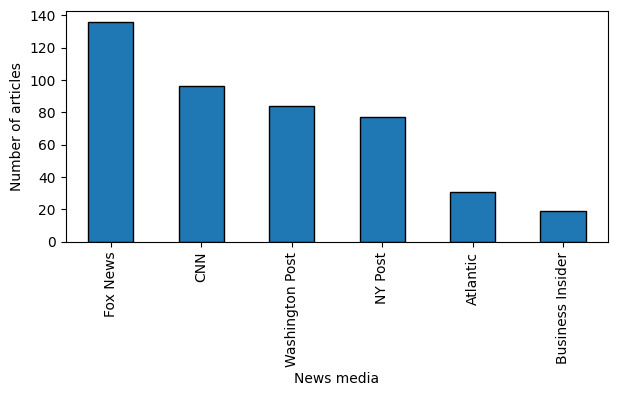

In [4]:
publications_count = data['name'].value_counts()
fig, ax = plt.subplots(figsize=(7, 3))
publications_count.plot(ax=ax, kind='bar', color='C0', edgecolor='k')
# ax.set_title('Number of articles by news media')
ax.set_ylabel('Number of articles')
ax.set_xlabel('News media')
# fig.tight_layout()
plt.savefig('figures/publication-distribution.png', bbox_inches='tight')

## Running TF-IDF

### Process Similar Articles

### Determine number of clusters
- The number of clusters is determined using the elbow method.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


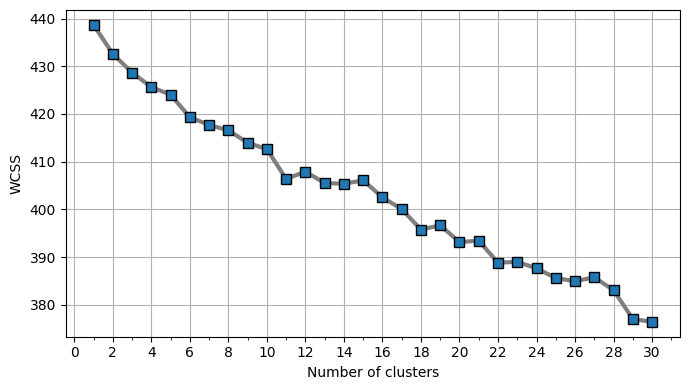

In [211]:
tfidf_dataframe, content_lowercase_dataframe = extract_documents(data.copy())

elbow_method(tfidf_dataframe)

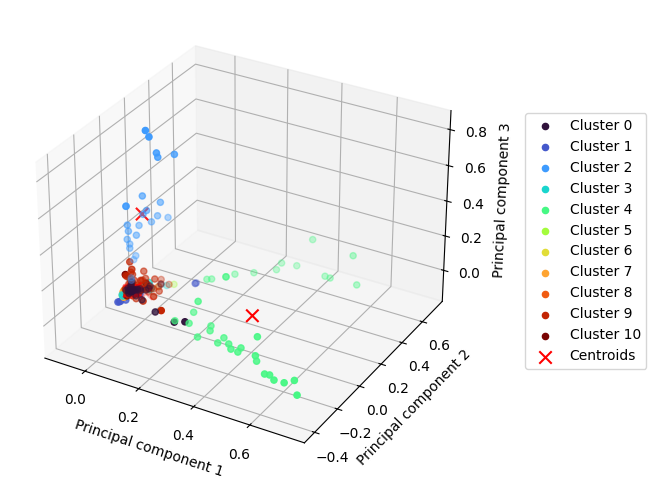

Clustering: Kmeans has converged! 02:53:16
First 20 entries in data with clusters:


,title,cluster
0,Two in custody after allegedly attacking Jewis...,9
1,Hamas frees 11 more hostages as US hopes two A...,4
2,NBA star at risk of losing $40 million over al...,3
3,Frosty the Joe-man: White House Christmas part...,2
4,Dave Portnoy quits gambling again after NFL he...,3


In [214]:
nr_clusters = 11 # Number of clusters
    
clustered_data = pd.DataFrame()

data = Cluster_Articles(k=int(nr_clusters), data=data.copy())

cluster_labels = data['cluster'].to_numpy()
    
if 'cluster' in data:
    # display dataframe header
    print("First 20 entries in data with clusters:")
    display(data[['title', 'cluster']].head(5))
    
    # Save clusters
    # clustered_path = text_area("Path", value="clustered_articles1.csv")
    # data.to_csv(os.path.join("data/", str(clustered_path)))

### Generating wordclouds for each cluster

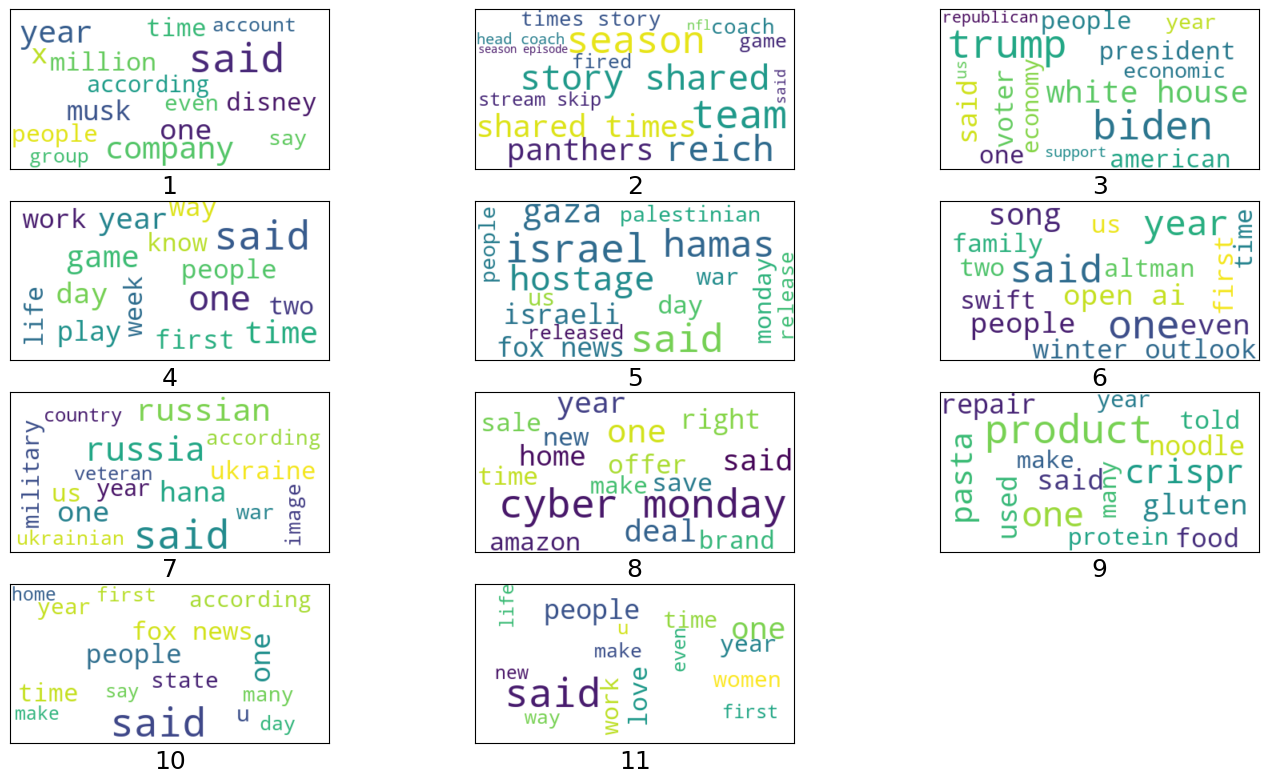

In [217]:
generate_wordclouds(content_lowercase_dataframe, cluster_labels)